This is an exercise for portoflio optimization:

1. Optimize weights to get Maximum Sharpe ratio with specific group

2. Debt to equity ratio as risk. Since it wil be expenisve to refinance in higher for longer interest environment, companies with higher debt to equity ratio will have signifiant finance impact to profit margin.

3. specific group = lowest 5 trailing PE (historical data) in non-cyclical sector. Trailing PE from yfinance and Sector Info wiki (Real Estate and  consumer staple goods, food, gasoline, utilities, and pharmaceuticals/healthcare)


In [119]:
import warnings 
warnings.filterwarnings('ignore')

Extract sp 500 company list and sector from wiki

In [120]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# Define the URL of the Wikipedia page for scraping
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Function to make the HTTP request and obtain the content
def get_html_content(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Error in obtaining page content, status code: {response.status_code}")

# Function to parse HTML content with BeautifulSoup
def parse_html_to_soup(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

# Get the HTML content of the Wikipedia page
html_content = get_html_content(URL)

# Parse the HTML content to get the BeautifulSoup object
soup = parse_html_to_soup(html_content)

# Verify that significant content was extracted
test_element = soup.find('h1', id="firstHeading")
assert test_element is not None, "The HTML content does not contain the expected element."
print("The HTML content has been successfully extracted and parsed.")

# Function to extract the data from the current S&P 500 constituents table
def extract_current_snp_data(soup):
    table = soup.find('table', {'id': 'constituents'})
    rows = table.find_all('tr')[1:]  # Exclude the table header
    current_data = []
    for row in rows:
        cols = row.find_all('td')
        symbol = cols[0].text.strip()
        security = cols[1].text.strip()
        gis_sector = cols[2].text.strip()
        gis_sub_ind = cols[3].text.strip()
        cik_code = cols[6].text.strip() #for EDGAR filing
        current_data.append({'Security': security, 'Symbol': symbol, 'GISC_Sector': gis_sector, 'GISC_SUB_INDUSTRY': gis_sub_ind, "CIK": cik_code})
    return current_data

# Extract data and create a DataFrame
current_data = extract_current_snp_data(soup)
dataframe_current = pd.DataFrame(current_data)

# Display the first records to confirm
print(dataframe_current.head())


The HTML content has been successfully extracted and parsed.
      Security Symbol             GISC_Sector               GISC_SUB_INDUSTRY  \
0           3M    MMM             Industrials        Industrial Conglomerates   
1  A. O. Smith    AOS             Industrials               Building Products   
2       Abbott    ABT             Health Care           Health Care Equipment   
3       AbbVie   ABBV             Health Care                   Biotechnology   
4    Accenture    ACN  Information Technology  IT Consulting & Other Services   

          CIK  
0  0000066740  
1  0000091142  
2  0000001800  
3  0001551152  
4  0001467373  


Get sector description

In [121]:
sector_list = dataframe_current['GISC_Sector'].unique()
sector_list

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [122]:
#setup non-cyclical sector: consumer staple goods, food, gasoline, utilities, and pharmaceuticals/healthcare


In [123]:
non_cyclical_sector = sector_list.tolist()
non_cyclical_sector.remove('Industrials')
non_cyclical_sector.remove('Information Technology')
non_cyclical_sector.remove('Financials')
non_cyclical_sector.remove('Materials')
non_cyclical_sector.remove('Consumer Discretionary')
non_cyclical_sector

['Health Care',
 'Utilities',
 'Real Estate',
 'Communication Services',
 'Consumer Staples',
 'Energy']

In [124]:
non_cyclical_sym = dataframe_current[dataframe_current['GISC_Sector'].isin(non_cyclical_sector)]
non_cyclical_sym.head()

,Security,Symbol,GISC_Sector,GISC_SUB_INDUSTRY,CIK
2,Abbott,ABT,Health Care,Health Care Equipment,0000001800
3,AbbVie,ABBV,Health Care,Biotechnology,0001551152
7,AES Corporation,AES,Utilities,Independent Power Producers & Energy Traders,0000874761
9,Agilent Technologies,A,Health Care,Life Sciences Tools & Services,0001090872
14,Alexandria Real Estate Equities,ARE,Real Estate,Office REITs,0001035443


In [125]:
len(non_cyclical_sym)

208

In [126]:
sym_list = " ".join(non_cyclical_sym['Symbol'])

In [127]:
sym_list

'ABT ABBV AES A ARE ALGN LNT GOOGL GOOG MO AEE AEP AMT AWK AMGN APA ADM T ATO AVB BKR BAX BDX BIO TECH BIIB BXP BSX BMY BF.B BG CPT CPB CAH CTLT CBRE COR CNC CNP CRL CHTR CVX CHD CI CLX CMS KO CL CMCSA CAG COP ED STZ CEG COO CSGP COST CTRA CCI CVS DHR DVA XRAY DVN DXCM FANG DLR DG DLTR D DTE DUK EIX EW EA ELV LLY ETR EOG EQT EQIX EQR ESS EL EVRG ES EXC EXR XOM FRT FE FOXA FOX GEHC GIS GILD HAL HCA DOC HSIC HSY HES HOLX HRL HST HUM IDXX ILMN INCY PODD IPG ISRG INVH IQV IRM JNJ K KVUE KDP KMB KIM KMI KHC KR LH LW LYV MRO MPC MTCH MKC MCK MDT MRK META MTD MAA MRNA MOH TAP MDLZ MNST NFLX NWSA NWS NEE NI NRG OXY OMC OKE PARA PEP PFE PCG PM PSX PNW PXD PPL PG PLD PEG PSA DGX O REG REGN RMD RVTY SBAC SLB SRE SPG SJM SO STE SYK SYY TMUS TTWO TRGP TGT TFX TMO TSN UDR UNH UHS VLO VTR VZ VRTX VTRS VICI WBA WMT DIS WBD WAT WEC WELL WST WY WMB XEL ZBH ZTS'

In [128]:
import yfinance as yf

yf_tickers = yf.Tickers(sym_list)




In [129]:
# get all stock info
yf_tickers.tickers['ABT'].info['trailingPE']

37.042946

In [130]:


df_tickerInfo = pd.DataFrame()

df_list = [] #Create a list to store the ticker info, ticker info is in dict format

for t in yf_tickers.symbols:
    _ = yf_tickers.tickers[t].info
    _['sym'] = t
    df_list.append(pd.DataFrame([_]))

df_tickerInfo = pd.concat(df_list) #convert list of dict to dataframe



In [131]:
df_tickerInfo = pd.DataFrame(df_tickerInfo).reset_index()
df_tickerInfo

,index,address1,address2,city,state,zip,country,phone,website,industry,...,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio,sym,fax,ask,bid
0,0,100 Abbott Park Road,Abbott Park,North Chicago,IL,60064-6400,United States,224 667 6100,https://www.abbott.com,Medical Devices,...,0.015,0.55324,0.26086,0.20086,USD,29.1691,ABT,NaN,NaN,NaN
1,0,1 North Waukegan Road,NaN,North Chicago,IL,60064-6400,United States,847 932 7900,https://www.abbvie.com,Drug Manufacturers - General,...,-0.054,0.69207,0.48525,0.31809,USD,0.4966,ABBV,NaN,NaN,NaN
2,0,4300 Wilson Boulevard,11th Floor,Arlington,VA,22203,United States,703 522 1315,https://www.aes.com,Utilities - Diversified,...,-0.030,0.19766,0.26563,0.14488,USD,1.1730,AES,NaN,NaN,NaN
3,0,5301 Stevens Creek Boulevard,NaN,Santa Clara,CA,95051,United States,800 227 9770,https://www.agilent.com,Diagnostics & Research,...,-0.056,0.50557,0.24350,0.24065,USD,2.8372,A,866 497 1134,NaN,NaN
4,0,26 North Euclid Avenue,NaN,Pasadena,CA,91101-6104,United States,626 578 0777,https://www.are.com,REIT - Office,...,0.130,0.70236,0.60097,0.25122,USD,NaN,ARE,626 578 0896,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0,220 Occidental Avenue South,NaN,Seattle,WA,98104-7800,United States,206 539 3000,https://www.weyerhaeuser.com,REIT - Specialty,...,-0.027,0.21918,0.20394,0.10147,USD,6.4617,WY,NaN,NaN,NaN
204,0,One Williams Center,NaN,Tulsa,OK,74172,United States,800-945-5426,https://www.williams.com,Oil & Gas Midstream,...,-0.125,0.59612,0.63190,0.44804,USD,1.8237,WMB,NaN,NaN,NaN
205,0,414 Nicollet Mall,NaN,Minneapolis,MN,55401,United States,612 330 5500,https://www.xcelenergy.com,Utilities - Regulated Electric,...,-0.151,0.41771,0.36463,0.19030,USD,2.2898,XEL,NaN,NaN,NaN
206,0,345 East Main Street,NaN,Warsaw,IN,46580,United States,574 373 3333,https://www.zimmerbiomet.com,Medical Devices,...,0.063,0.71818,0.33119,0.23700,USD,2.4796,ZBH,NaN,NaN,NaN


In [132]:
non_cyclical_sym_Info = non_cyclical_sym.merge(df_tickerInfo, left_on='Symbol', right_on='sym')


In [133]:
non_cyclical_sym_Info = non_cyclical_sym_Info[['Security', 'Symbol', 'GISC_Sector','trailingPE','forwardPE','priceToBook','quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity']]
non_cyclical_sym_Info.dropna(inplace= True) #since we will use debt to equity and PE, remove row with na

In [134]:
grp_non_cyclical_PE = non_cyclical_sym_Info.groupby('GISC_Sector')['trailingPE'].mean()

In [135]:
grp_non_cyclical_PE = pd.DataFrame(grp_non_cyclical_PE).reset_index()
grp_non_cyclical_PE.columns = ['GISC_Sector', 'AvgPE']
grp_non_cyclical_PE

,GISC_Sector,AvgPE
0,Communication Services,26.743569
1,Consumer Staples,32.871475
2,Energy,13.228558
3,Health Care,59.969764
4,Real Estate,50.479900
5,Utilities,19.292007


In [136]:
non_cyclical_PE_belowAvg = non_cyclical_sym_Info.merge(grp_non_cyclical_PE, left_on='GISC_Sector', right_on='GISC_Sector')
non_cyclical_PE_belowAvg = non_cyclical_PE_belowAvg[non_cyclical_PE_belowAvg['trailingPE'] < non_cyclical_PE_belowAvg['AvgPE']]



non_cyclical_PE_belowAvg[['Security','Symbol', 'GISC_Sector','AvgPE','trailingPE']]


,Security,Symbol,GISC_Sector,AvgPE,trailingPE
0,Abbott,ABT,Health Care,59.969764,37.042946
2,Agilent Technologies,A,Health Care,59.969764,35.368423
3,Align Technology,ALGN,Health Care,59.969764,53.473320
4,Amgen,AMGN,Health Care,59.969764,22.123201
5,Becton Dickinson,BDX,Health Care,59.969764,54.671270
...,...,...,...,...,...
178,Procter & Gamble,PG,Consumer Staples,32.871475,27.078594
179,Sysco,SYY,Consumer Staples,32.871475,19.591686
180,Target Corporation,TGT,Consumer Staples,32.871475,18.722906
181,Walgreens Boots Alliance,WBA,Consumer Staples,32.871475,32.242424


In [137]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

non_cyclical_PE_belowAvg['scaled_debtToEquity'] = scaler.fit_transform(non_cyclical_PE_belowAvg[['debtToEquity']]) #consider debt to equity is a 'risk'
non_cyclical_PE_belowAvg.head(20)

,Security,Symbol,GISC_Sector,trailingPE,forwardPE,priceToBook,quickRatio,currentRatio,totalRevenue,debtToEquity,AvgPE,scaled_debtToEquity
0,Abbott,ABT,Health Care,37.042946,23.632093,5.424734,1.000,1.638,4.010900e+10,40.881,59.969764,0.038014
2,Agilent Technologies,A,Health Care,35.368423,24.236065,7.001326,1.882,2.683,6.735000e+09,43.940,59.969764,0.040930
3,Align Technology,ALGN,Health Care,53.473320,29.588572,6.424583,0.977,1.184,3.862260e+09,3.488,59.969764,0.002360
4,Amgen,AMGN,Health Care,22.123201,13.087554,23.757732,1.027,1.649,2.819000e+10,1049.791,59.969764,1.000000
5,Becton Dickinson,BDX,Health Care,54.671270,16.584380,2.712239,0.457,1.082,1.949200e+10,63.595,59.969764,0.059671
6,Bio-Techne,TECH,Health Care,53.323742,36.693070,5.931973,2.537,4.368,1.144999e+09,28.301,59.969764,0.026019
7,Biogen,BIIB,Health Care,28.491228,12.903518,2.226073,1.042,1.997,9.835600e+09,50.195,59.969764,0.046895
9,Bristol Myers Squibb,BMY,Health Care,14.093265,7.651196,3.735751,1.237,1.427,4.500600e+10,140.821,59.969764,0.133306
10,Cencora,COR,Health Care,25.836780,16.274160,51.944870,0.482,0.884,2.715794e+11,582.062,59.969764,0.554025
11,Centene Corporation,CNC,Health Care,15.505051,10.098684,1.587515,0.958,1.110,1.412660e+11,72.727,59.969764,0.068379


In [138]:
belowAvgPE = non_cyclical_PE_belowAvg.groupby('GISC_Sector')['trailingPE'].nsmallest(5)

In [139]:
belowAvgPE = pd.DataFrame(belowAvgPE).reset_index()
belowAvgPE

,GISC_Sector,level_1,trailingPE
0,Communication Services,113,8.730965
1,Communication Services,114,9.823334
2,Communication Services,119,11.421053
3,Communication Services,115,11.640161
4,Communication Services,123,13.726483
5,Consumer Staples,151,7.250000
6,Consumer Staples,150,7.937413
7,Consumer Staples,172,13.372244
8,Consumer Staples,157,13.873171
9,Consumer Staples,170,14.978354


In [140]:
non_cyclical_PE_belowAvg_btm5 = non_cyclical_PE_belowAvg.loc[belowAvgPE['level_1']]


In [141]:
non_cyclical_PE_belowAvg_btm5.describe()

,trailingPE,forwardPE,priceToBook,quickRatio,currentRatio,totalRevenue,debtToEquity,AvgPE,scaled_debtToEquity
count,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000
mean,12.816454,12.416745,3.054874,1.647067,1.975600,5.086773e+10,143.735033,33.764212,0.136084
std,4.962518,5.176497,3.250069,4.294306,4.227185,7.492031e+10,157.997553,16.853268,0.150649
min,3.398919,6.563674,0.850917,0.239000,0.284000,1.783400e+09,37.137000,13.228558,0.034444
25%,8.862863,9.392288,1.297845,0.431000,0.742500,8.792075e+09,70.613500,19.292007,0.066363
50%,12.475268,10.902467,1.907906,0.658500,1.018000,1.467760e+10,101.768000,29.807522,0.096069
75%,15.373377,13.597870,3.477715,1.052250,1.426750,5.830675e+10,139.375250,50.479900,0.131927
max,26.247517,26.035843,16.460815,23.836000,23.839000,3.566230e+11,719.121000,59.969764,0.684709


In [142]:
import pandas as pd
from datetime import datetime, timedelta
from scipy.optimize import minimize
import numpy as np


In [143]:
#setup ticker list and assign additional volatility metric which is debt to equity ratio
tickers =  non_cyclical_PE_belowAvg_btm5['Symbol'].to_list()
tickers_x_volatility = non_cyclical_PE_belowAvg_btm5['scaled_debtToEquity'].to_list() #smaller number is better


In [144]:

end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)


In [145]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [146]:
print(adj_close_df.head())

                    T        CHTR        IPG      CMCSA        OMC         BG  \
Date                                                                            
2019-03-15  15.597737  355.920013  18.270039  36.017200  62.794296  45.500668   
2019-03-18  15.663850  357.350006  18.163715  35.527714  62.053768  44.949768   
2019-03-19  15.602828  360.450012  18.220964  35.403114  62.993977  44.803429   
2019-03-20  15.516363  362.440002  17.942911  35.127232  61.820786  44.252537   
2019-03-21  15.796078  366.269989  17.934731  35.643414  62.419876  45.010017   

                  ADM         LW        CAG        KHC  ...       VICI  \
Date                                                    ...              
2019-03-15  37.746624  65.223740  19.447489  25.400923  ...  16.619423   
2019-03-18  37.134708  65.589699  19.430641  25.353430  ...  16.573124   
2019-03-19  37.598015  65.411438  19.211660  25.432585  ...  16.503691   
2019-03-20  36.977352  65.092377  19.287460  25.345514  ...  1

In [147]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()
log_returns

,T,CHTR,IPG,CMCSA,OMC,BG,ADM,LW,CAG,KHC,...,VICI,KIM,HST,SPG,PSA,ETR,ED,PEG,SRE,PCG
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-18,0.004230,0.004010,-0.005837,-0.013684,-0.011863,-0.012181,-0.016344,0.005595,-0.000867,-0.001871,...,-0.002790,-0.007388,0.002086,-0.010045,0.000643,-0.001797,-0.001651,-0.002011,0.000241,-0.011259
2019-03-19,-0.003903,0.008638,0.003147,-0.003513,0.015038,-0.003261,0.012399,-0.002722,-0.011334,0.003117,...,-0.004198,0.004553,-0.005746,-0.005349,-0.001287,-0.013961,-0.010563,-0.008254,-0.005793,-0.018702
2019-03-20,-0.005557,0.005506,-0.015378,-0.007823,-0.018799,-0.012372,-0.016646,-0.004890,0.003938,-0.003429,...,0.002801,0.005098,0.001570,0.003109,0.006280,0.004177,0.000358,-0.003898,0.008997,0.000524
2019-03-21,0.017867,0.010512,-0.000456,0.014588,0.009644,0.016972,0.013618,0.023225,0.120012,0.022542,...,0.014349,0.026207,0.001568,0.024084,0.014381,0.014641,0.006538,0.009969,0.014307,-0.001574
2019-03-22,0.000322,-0.015102,-0.037162,-0.014841,-0.026337,-0.011347,-0.006082,0.009253,0.024107,-0.014146,...,0.006413,-0.002204,-0.018446,-0.003260,0.000450,0.012247,0.006143,0.002519,0.001588,0.019236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,0.000582,-0.016225,0.001571,0.002138,0.017144,0.004800,0.012824,-0.006907,0.008985,0.006243,...,0.000691,-0.007228,0.006233,0.016282,0.014985,0.006447,0.009618,0.010535,0.006106,0.003645
2024-03-07,-0.007596,0.020311,0.021433,-0.009775,0.023346,0.006617,0.001845,-0.026811,-0.005381,-0.012959,...,0.002761,0.003104,-0.005272,-0.004466,0.008248,0.001362,0.001001,0.014975,-0.000566,0.006046
2024-03-08,0.008759,0.006292,-0.008642,0.019925,-0.003810,-0.003140,0.010270,0.014533,0.011801,0.009807,...,0.003440,0.006692,0.003358,0.008382,0.024345,0.004947,0.001999,-0.015442,0.006635,-0.001810


In [148]:
log_returns.describe()

,T,CHTR,IPG,CMCSA,OMC,BG,ADM,LW,CAG,KHC,...,VICI,KIM,HST,SPG,PSA,ETR,ED,PEG,SRE,PCG
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,...,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,0.000078,-0.000150,0.000460,0.000145,0.000328,0.000575,0.000329,0.000365,0.000303,0.000246,...,0.000458,0.000264,0.000189,0.000105,0.000397,0.000216,0.000193,0.000193,0.000231,-0.000147
std,0.016633,0.020622,0.022873,0.017594,0.019859,0.021139,0.019463,0.022697,0.017350,0.017922,...,0.022390,0.026216,0.025775,0.030444,0.016367,0.017614,0.015363,0.015834,0.017487,0.038852
min,-0.109883,-0.180461,-0.165692,-0.095748,-0.109317,-0.154103,-0.277034,-0.196867,-0.128950,-0.148007,...,-0.337382,-0.220877,-0.170646,-0.310783,-0.122520,-0.171134,-0.140809,-0.118654,-0.187723,-0.364643
25%,-0.007331,-0.009314,-0.010407,-0.008068,-0.008753,-0.009306,-0.007843,-0.008342,-0.007857,-0.007292,...,-0.007891,-0.011443,-0.012782,-0.011419,-0.007316,-0.007233,-0.006622,-0.007257,-0.007550,-0.013543
50%,0.000522,0.000875,0.000621,0.000636,0.000356,0.001277,0.001686,0.000572,0.000552,0.000602,...,0.001145,0.001064,0.000562,0.000347,0.000856,0.000670,0.000890,0.000856,0.000814,0.000000
75%,0.007598,0.010116,0.011770,0.009451,0.009489,0.012313,0.009830,0.010669,0.008623,0.008578,...,0.009644,0.011813,0.012403,0.011447,0.009132,0.008598,0.007161,0.007965,0.008808,0.013679
max,0.095513,0.093981,0.136922,0.118355,0.137530,0.135199,0.097758,0.142919,0.147292,0.178075,...,0.162939,0.279609,0.262584,0.245839,0.061670,0.138448,0.165632,0.101065,0.107574,0.280419


In [149]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,T,CHTR,IPG,CMCSA,OMC,BG,ADM,LW,CAG,KHC,...,VICI,KIM,HST,SPG,PSA,ETR,ED,PEG,SRE,PCG
T,0.069720,0.029502,0.044817,0.037190,0.038377,0.029768,0.031463,0.034247,0.020069,0.031334,...,0.038245,0.050068,0.041532,0.051215,0.023545,0.035685,0.029027,0.030520,0.035190,0.031108
CHTR,0.029502,0.107162,0.041944,0.059245,0.031197,0.027277,0.026960,0.030865,0.013204,0.022945,...,0.043675,0.037738,0.037677,0.046149,0.027440,0.032454,0.019920,0.027712,0.032015,0.033482
IPG,0.044817,0.041944,0.131843,0.056522,0.096078,0.056125,0.053157,0.068001,0.021933,0.040387,...,0.068505,0.090084,0.089288,0.104200,0.032817,0.043528,0.028076,0.040487,0.047501,0.059390
CMCSA,0.037190,0.059245,0.056522,0.078005,0.046944,0.034658,0.034798,0.038539,0.017117,0.028622,...,0.042365,0.050963,0.052169,0.059868,0.024533,0.034595,0.023098,0.030765,0.033177,0.038858
OMC,0.038377,0.031197,0.096078,0.046944,0.099382,0.043685,0.043494,0.054966,0.020720,0.032796,...,0.051460,0.073733,0.074013,0.084377,0.026042,0.035231,0.024896,0.033922,0.037554,0.046238
BG,0.029768,0.027277,0.056125,0.034658,0.043685,0.112607,0.071485,0.047669,0.019403,0.030181,...,0.056600,0.057546,0.059953,0.076178,0.026182,0.037347,0.020071,0.034020,0.036728,0.050950
ADM,0.031463,0.026960,0.053157,0.034798,0.043494,0.071485,0.095462,0.040857,0.024616,0.036754,...,0.046044,0.054230,0.052960,0.063310,0.029253,0.037689,0.027786,0.034652,0.039169,0.045724
LW,0.034247,0.030865,0.068001,0.038539,0.054966,0.047669,0.040857,0.129815,0.023625,0.035191,...,0.067938,0.081577,0.070743,0.097502,0.025906,0.043670,0.022134,0.040498,0.042567,0.055300
CAG,0.020069,0.013204,0.021933,0.017117,0.020720,0.019403,0.024616,0.023625,0.075857,0.036139,...,0.018332,0.019753,0.012674,0.017847,0.018633,0.026355,0.024322,0.024423,0.021342,0.025233
KHC,0.031334,0.022945,0.040387,0.028622,0.032796,0.030181,0.036754,0.035191,0.036139,0.080940,...,0.037941,0.039351,0.032520,0.037951,0.023005,0.034794,0.030951,0.030285,0.036195,0.040997


In [150]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [151]:
from fredapi import Fred

filename = 'apikey'
api_key = get_file_contents(filename)
fred = Fred(api_key=api_key) 
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
print(risk_free_rate)

0.0421


Calculate Standard Deviation, expected returns, sharpe ratio, negative sharpe ratio

In [152]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights #https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/#:~:text=In%20finance%2C%20the%20covariance%20matrix,risk%20and%20enhance%20potential%20returns.
    #variance = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    return np.sqrt(variance)

In [153]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [154]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [155]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Define volatitity function and frontier function

In [156]:
def x_volatility(weights, tickers_x_volatility):
    return np.dot(weights.T, tickers_x_volatility)

In [157]:
def negative_x_frontier(weights, log_returns, cov_matrix, risk_free_rate, tickers_x_volatility):
    return neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + -1*( x_volatility(weights, tickers_x_volatility)) #optimization like ESG, https://www.esgperspectives.com/Quant.html

Set constraints

In [158]:
#https://optimization.cbe.cornell.edu/index.php?title=Portfolio_optimization#:~:text=Portfolio%20optimization%20is%20a%20way,or%20all%20the%20original%20investment.

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} #sum of weight = 1
bounds = [(0, 0.5) for _ in range(len(tickers))] #ticket weight larger than zero (can't go short) but lesser than 50% for any single security (sometimes security may outperform in some period and for diverisfication)



Setup Init weights

In [159]:
initial_weights = np.array([1/len(tickers)]*len(tickers)) #set weights to equal weight per tickers
initial_weights


array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

Portfolio Optimization

In [160]:

optimized_results = minimize(negative_x_frontier, initial_weights, args=(log_returns, cov_matrix, risk_free_rate, tickers_x_volatility), method='SLSQP', constraints=constraints, bounds=bounds)


In [161]:
print(optimized_results) #result is in 'x' variable

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6186940099622272
       x: [ 8.613e-17  4.432e-02 ...  0.000e+00  5.338e-16]
     nit: 7
     jac: [-1.134e-01 -4.950e-01 ... -1.516e-01 -2.384e-02]
    nfev: 217
    njev: 7


Optimze the weights by using minimize negative sharp ratio. SLSQP stands for Sequential least squires quadratic programming, for numerical optimization technique for solving nonliner opimiization problems with constraints 

Analyze optimal portfolio

In [162]:
optimized_weights = optimized_results.x
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

optimal_x_volatility = x_volatility(optimal_weights, tickers_x_volatility)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

print(f"X Volatility: {optimal_x_volatility:.4f}")


Optimal Weights:
T: 0.0000
CHTR: 0.0443
IPG: 0.0000
CMCSA: 0.0000
OMC: 0.0000
BG: 0.0000
ADM: 0.0000
LW: 0.0000
CAG: 0.0000
KHC: 0.0000
APA: 0.0000
VLO: 0.0000
MPC: 0.4557
DVN: 0.0000
EQT: 0.0000
CVS: 0.0000
BMY: 0.0000
CNC: 0.0000
GILD: 0.0000
UHS: 0.0000
VICI: 0.0000
KIM: 0.0000
HST: 0.0000
SPG: 0.5000
PSA: 0.0000
ETR: 0.0000
ED: 0.0000
PEG: 0.0000
SRE: 0.0000
PCG: 0.0000
Expected Annual Return: 0.1283
Expected Volatility: 0.4126
Sharpe Ratio: 0.2089
X Volatility: 0.4098


Display the Final Portfolio in a Plot

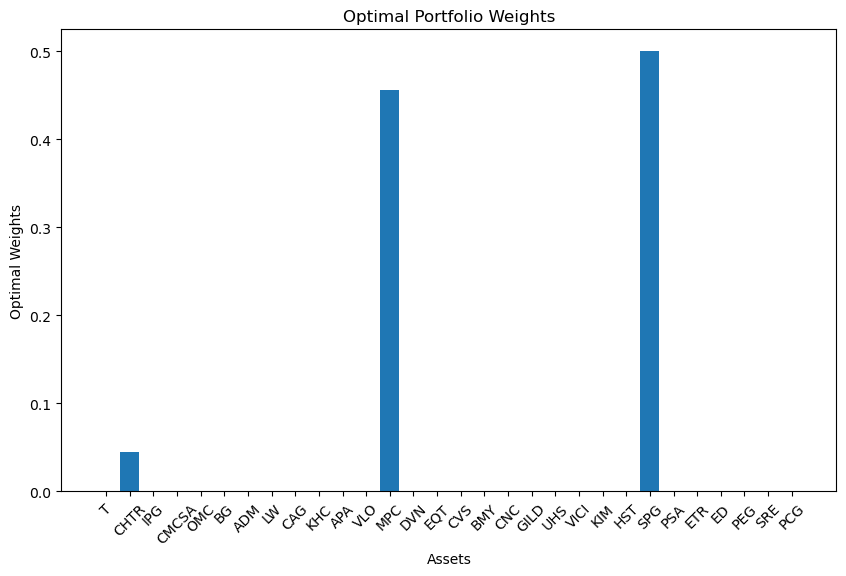

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.xticks(rotation = 45)
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()